In [1]:
l1ascan = pd.read_hdf('/home/klay6683/to_keep/l1a_dark_scan.h5', 'df')

In [2]:
from iuvs import meta

In [3]:
l1ascan = meta.clean_up_dark_scan(l1ascan)

In [4]:
l1ascan.columns

Index(['ANC_SVN_REVISION', 'BIN_PATTERN_INDEX', 'BIN_TBL', 'CADENCE',
       'CASE_TEMP', 'CHANNEL', 'CODE_SVN_REVISION', 'COLLECTION_ID',
       'DET_TEMP', 'DUTY_CYCLE', 'FILENAME', 'FOV_DEG', 'INT_TIME',
       'LYA_CENTROID', 'MCP_VOLT', 'MIRROR_DEG', 'MIRROR_DN', 'MIR_DEG',
       'MISSION_PHASE', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'N_FILL',
       'OBS_ID', 'ORBIT_NUMBER', 'PROCESS', 'PRODUCT_ID', 'SOLAR_LONGITUDE',
       'TARGET_NAME', 'TIME_OF_INT', 'mean', 'median', 'std', 'BINNING_SET'],
      dtype='object')

In [5]:
l1ascan.NAXIS3.value_counts(dropna=False)

 21     29757
 2       8718
NaN      7279
 226     2034
 104     1040
 88       880
 60       600
 97       388
 112      336
 49       196
 39        78
Name: NAXIS3, dtype: int64

In [6]:
def process_fname(fname):
    import pandas as pd
    l1a = io.L1AReader(fname)
    d = dict(fname=l1a.fname)
    if l1a.n_dims == 2:
        d['selfsub_mean'] = np.NAN
        d['selfsub_std'] = np.NAN
        return d
    elif l1a.img_header['NAXIS3'] == 2:
        ioffset = 0
        d['danger'] = '1vs2'
    else:
        ioffset = 1
    sub = l1a.primary_img_dn_s[0+ioffset] - l1a.primary_img_dn_s[1+ioffset]
    d['selfsub_mean'] = sub.mean()
    d['selfsub_std'] = sub.std()
    return d

In [ ]:
process_fname(l1ascan.PRODUCT_ID.iloc[10000])

In [ ]:
from IPython.parallel import Client
c = Client()

In [ ]:
dview = c.direct_view()
lview = c.load_balanced_view()

In [ ]:
doing = l1ascan.PRODUCT_ID.unique()
results = lview.map_async(process_fname, doing)

In [ ]:
from iuvs.multitools import nb_progress_display

In [ ]:
nb_progress_display(results, doing)

In [ ]:
resdf = pd.DataFrame(results.result)
resdf.head()

In [ ]:
resdf.to_hdf("/home/klay6683/to_keep/dark_minus_dark.h5", "df")

In [7]:
resdf = pd.read_hdf("/home/klay6683/to_keep/dark_minus_dark.h5")

In [8]:
pd.__version__

'0.16.2+535.gf82e177'

In [11]:
from pathlib import Path
from iuvs import io
def complete_product_id(pid):
    fname = io.productionlevel1apath / Path(pid)
    if fname.suffix == '.fits' or fname.suffix == '':
        fname = fname.with_suffix('.fits.gz')
    return str(fname)

In [12]:
l1ascan['fname'] = l1ascan.PRODUCT_ID.map(complete_product_id)

In [13]:
merged = l1ascan.merge(resdf, on='fname')

In [14]:
merged.COLLECTION_ID.value_counts()

limb           19085
disk           18143
corona          5646
cruise          4362
transition      3422
occultation      434
calibration      214
Name: COLLECTION_ID, dtype: int64

In [15]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

/usr/local/python3/miniconda/lib/python3.4/site-packages/matplotlib-1.5.dev1-py3.4-linux-x86_64.egg/matplotlib/__init__.py:866: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [16]:
%matplotlib nbagg

In [17]:
no_danger = merged[merged.danger.isnull()]

<IPython.core.display.Javascript object>


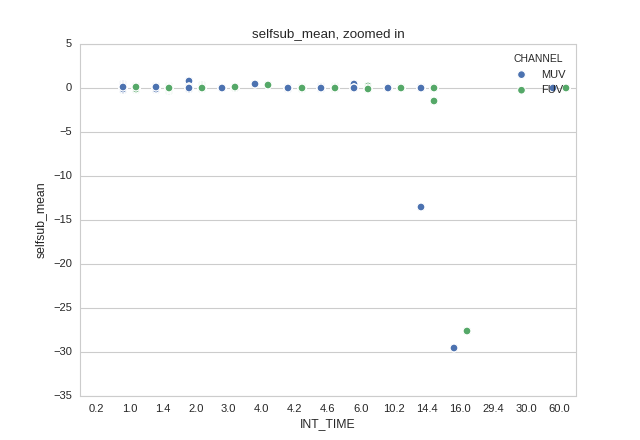

/usr/local/python3/miniconda/lib/python3.4/site-packages/matplotlib-1.5.dev1-py3.4-linux-x86_64.egg/matplotlib/__init__.py:886: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [18]:
plt.figure()
ax = sns.stripplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=merged.sort_values(by='INT_TIME'))
ax.set_title('selfsub_mean, zoomed in')

<IPython.core.display.Javascript object>


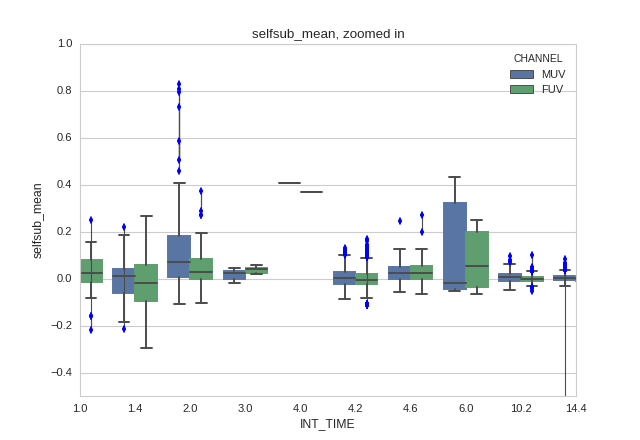

/usr/local/python3/miniconda/lib/python3.4/site-packages/matplotlib-1.5.dev1-py3.4-linux-x86_64.egg/matplotlib/__init__.py:886: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(1.0, 10)

In [19]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=merged.sort_values(by='INT_TIME'))
ax.set_title('selfsub_mean, zoomed in')
ax.set_ylim(-0.5, 1)
ax.set_xlim(1.0, 10)

In [ ]:
merged['NAXIS3'] = merged.NAXIS3.fillna(1)

In [ ]:
plt.figure()
ax = sns.countplot(x='NAXIS3', data=merged.sort_values(by='NAXIS3'))
ax.set_title('Number of darks taken per L1A file.')

In [ ]:
plt.figure()
ax = sns.countplot(x='NAXIS3', hue='INT_TIME', 
                   data=merged[merged.INT_TIME.isin([14.4, 4.2, 1.4])].sort_values(by='NAXIS3'))
ax.set_title('Filtered for INT_TIMES 14.4, 4.2, 1.4')

In [ ]:
with_danger = merged[merged.danger=='1vs2']

In [ ]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=no_danger.sort_values(by='INT_TIME'))
ax.set_title('Without 1vs2 subtractions.')
ax.set_ylim(-0.5, 1)
ax.set_xlim(1,9)

In [ ]:
sns.boxplot?

In [ ]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=with_danger.sort_values(by='INT_TIME'))
ax.set_title("Only subtractions of first vs second.")
ax.set_ylim(-0.5, 1)
ax.set_xlim(0, 9)

In [ ]:
to_plot = merged[merged.COLLECTION_ID.isin(['limb','disk','corona','occulation'])]

In [ ]:
to_plot.INT_TIME.value_counts()